# Lung Diseases Classification - Phase 1: Classifier Head Architecture Search with Optuna

<div style="text-align: center;">
    <img src="../../images/optuna.png" alt="Crop with image and mask" style="display: block; margin: 0 auto;">
</div>


## Context

This notebook is part of a **multi-stage medical imaging pipeline** for lung analysis.
We use DenseNet121 from DenseNet models Family. [DenseNet121 in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/DenseNet121)  
Also for Architecture searching using Optuna. [Optuna Official Site](https://optuna.org)

In earlier stages of the project, a **binary lung health classifier** was developed to distinguish between `healthy` and `unhealthy` lungs.  
That model serves as a **coarse screening mechanism**, ensuring that only clinically relevant cases are forwarded to more detailed analysis.

The present notebook operates **downstream of that stage**, focusing on **disease-level classification** for lungs identified as abnormal.

---

## Purpose of This Notebook

This notebook implements **Phase 1 of a two-phase hyperparameter optimization strategy**, where the objective is to identify the most effective **classifier head architecture** on top of a frozen convolutional backbone.

Key characteristics of this phase:

- The feature extractor (`DenseNet121`) is **fully frozen**
- Architectural capacity is explored **independently of optimization dynamics**
- Regularization and training behavior are intentionally constrained

The goal is to answer a single question:

> *Given a fixed feature extractor, what head architecture best represents the task?*

---

## Problem Setting

This notebook is responsible for:

- Preparing a **distributed TensorFlow training environment**
- Building efficient **tf.data pipelines** from TFRecord files
- Applying lung-specific preprocessing and ROI-based transformations
- Defining a **search space for classifier head architectures**
- Running an **Optuna-based architecture search**
- Evaluating candidates using a **penalized, stability-aware F1 score**
- Persisting the best-performing architecture and metadata for downstream phases

All reusable components (data parsing, preprocessing, cleanup utilities, strategy helpers) are abstracted into a shared `utils.py` module to maintain modularity and clarity.


## Optimization Strategy

To avoid confounding factors, the optimization process is **explicitly staged**:

### Phase 1 — Architecture Search (This Notebook)
- Search over:
  - Number of dense layers
  - Width and reduction pattern of each layer
- Fixed optimizer and learning rate
- Minimal, phase-aware dropout usage
- Architecture ranking based on validation stability

### Phase 2 — Optimization & Regularization (Subsequent Notebook)
- Learning rate tuning
- Weight decay
- Dropout scheduling
- Training dynamics and convergence behavior

This separation follows **best practices in deep learning experimentation**, particularly in safety-critical domains such as medical AI.

## Evaluation Philosophy

Architecture candidates are evaluated using a `penalized macro F1 score`, computed over a rolling window of validation epochs.

This discourages:
- Unstable architectures
- Precision–recall imbalance
- Over-optimistic single-epoch peaks

Only architectures demonstrating **consistent and balanced performance** are promoted to the next phase.

## Design Principles

Several design principles guide this notebook:

- **Reproducibility** via fixed seeds and serialized metadata
- **Modularity** through shared utilities in `utils.py`
- **Clarity over cleverness** in experimental design
- **Separation of concerns** between architecture and optimization

## Outcome

The output of this notebook is a **locked classifier head architecture**, serialized along with its metadata and ready to be reused in downstream training and fine-tuning stages.

All subsequent experiments build upon the architectural decisions made here.


## Outputs

At the end of the optimization process, this notebook produces:
- The **best head architecture configuration**
- Associated metadata (trial index, score, seed, training setup)
- A serialized JSON artifact to be reused in subsequent training phases

---

## Section 1 - Environment Setup and Experiment Foundations

This section initializes the experimental environment used throughout the notebook.  
It focuses on **dependency imports**, **runtime configuration**, and **distributed training setup**.

The goal here is not model logic, but to ensure:
- A stable TensorFlow runtime
- Correct hardware utilization (CPU / GPU / multi-replica)
- Consistent behavior across runs

All domain-specific helpers (seeding, distribution strategy) are provided via the shared `utils.py` module.


---
### 1.1 Imports and Core Dependencies

This subsection loads all required libraries for:
- Numerical computation
- Visualization
- Deep learning with TensorFlow / Keras
- Hyperparameter optimization with Optuna

Project-specific utilities are imported from `utils.py` to keep the notebook modular and concise.

In [3]:
# Import necessary libraries
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.integration import TFKerasPruningCallback
import os
import random
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import metrics
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
import time
# Project-wide helper utilities (seeding, strategy, cleanup, preprocessing, etc.)
from utils import *

### 1.2 Runtime Verification

A lightweight sanity check to confirm the active `TensorFlow` version.  
This is useful for reproducibility and debugging environment-related issues.


In [5]:
# Print TensorFlow version for reproducibility and environment verification
print(tf.__version__)

2.20.0


### 1.3 Reproducibility and Random Seed Control

This subsection initializes a global random seed to ensure `reproducible` behavior
across experiments. All relevant random number generators (Python, NumPy,
TensorFlow) are synchronized via a shared utility function.


In [6]:
# Global seed for reproducibility across Python, NumPy, and TensorFlow
SEED = 28

# Seed initialization logic is centralized inside utils.py
seed_everthing()

For reproducibility, everything seeded!


---
### 1.4 GPU Memory Configuration

This subsection configures TensorFlow to use GPU memory more safely by enabling
dynamic memory growth. This prevents TensorFlow from pre-allocating all available
GPU memory at startup and improves stability when running multiple experiments.


In [8]:
# Configure TensorFlow to allocate GPU memory dynamically instead of pre-allocating all memory
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for each available GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before TensorFlow initializes GPUs
        print(e)

Enabled memory growth for 1 GPU(s)


---
### 1.5 Distributed Training Strategy Initialization

The training strategy is initialized via a helper function defined in `utils.py`.  
This abstraction allows the same codebase to scale seamlessly across different
hardware setups (single GPU, multi-GPU, TPU) without modifying model logic.

In [9]:
# Initialize the distributed training strategy
# The exact strategy (MirroredStrategy, TPU, etc.) is defined inside utils.py
strategy = get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU strategy: MirroredStrategy
REPLICAS: 1


I0000 00:00:1768903288.287705    9165 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


---
## Section 2 - Configuration Management and Dataset Semantics

This section defines all **global constants**, **algorithm configurations**, and
**dataset-related hyperparameters** used throughout the experiment.

Rather than scattering values across the notebook, parameters are deliberately
*bagged* into structured configuration objects. This approach reflects
**professional experimentation practices** in large-scale deep learning systems.

In addition, class-mapping metadata is explicitly loaded and printed to make the
label space **transparent** before any transformations are applied in subsequent
sections.


### 2.1 Global Constants and Runtime Parameters

Core constants such as image resolution, dataset paths, and class counts are
defined once and reused everywhere.

This eliminates *hidden dependencies* and ensures that changes propagate
consistently across the pipeline.

Key symbols used throughout the notebook include:

- Image domain: $H \times W$
- Number of classes: $C = 3$
- TensorFlow parallelism: `AUTO = tf.data.AUTOTUNE`

#### 2.1.1 Hyperparameter Bagging and Configuration Objects

Instead of passing dozens of individual arguments, related hyperparameters are
grouped into **semantic configuration dictionaries**:

- `PENALIZED_F1_CONFIG`
- `ARCHITECTURE_CONFIG`
- `MODEL_CONFIG`
- `DATASET_CONFIG`

This design has several advantages:

- **Clarity**: each configuration has a single responsibility
- **Traceability**: configurations can be logged or serialized as metadata
- **Reproducibility**: experiments are defined by explicit parameter bundles
- **Scalability**: adding new parameters does not pollute function signatures

Professionally, this mirrors how experiments are defined in production ML systems
and research codebases.

In [28]:
# TensorFlow autotuning for parallel data pipeline execution
AUTO = tf.data.AUTOTUNE

# Project directory structure
DATA_DIR = '../../data/tfrecords/'
MODELS_DIR = '../../models/'

# Image and mask spatial resolution
IMAGE_SIZE = (256, 256)
MASK_SIZE = IMAGE_SIZE

# Backbone unfreezing anchor (used in later phases)
UNFREEZE_LAYER = 'conv5_block1_0_bn'

# Dataset shuffling and class configuration
SHUFFLE_SIZE = 1024
NUM_CLASSES = 3

# Algorithm-specific configuration bundles
PENALIZED_F1_CONFIG = {'alpha_p': 0.2, 'stage_arch': 7, 'K_arch': 4}
ARCHITECTURE_CONFIG = {'arch_trials': 20, 'arch_epoch': 7}
MODEL_CONFIG = {
    'img_size': IMAGE_SIZE,
    'mask_size': MASK_SIZE,
    'num_classes': NUM_CLASSES
}

#### 2.1.2 Effective Batch Size Under Distribution

When using a distributed training strategy, the *effective* batch size is:

$$
\text{Global Batch Size} = \text{Batch Size per Replica} \times N_{\text{replicas}}
$$


This value is computed explicitly to avoid silent scaling errors and is printed
for visibility during runtime.

In [29]:
# Batch size defined per replica
BATCH_SIZE_PER_REPLICA = 8

# Effective global batch size under the active distribution strategy
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Dataset configuration bundle
DATASET_CONFIG = {
    "shuffle": SHUFFLE_SIZE,
    "batch_size": GLOBAL_BATCH_SIZE,
    'auto': AUTO
}

# Print for runtime visibility and debugging
print(f'Global Batch size: {GLOBAL_BATCH_SIZE}')

Global Batch size: 8


---
### 2.2 Class Mapping and Label Semantics

Before performing any label remapping or filtering, the original dataset class
definitions are loaded and printed.

This step serves two purposes:

1. It documents the **semantic meaning** of class indices
2. It allows the reader to understand how later transformations reshape the label space

Two mappings are inspected:
- The **original dataset class mapping**
- The **subset mapping for unhealthy lung conditions**

Making label semantics explicit is especially important in medical datasets,
where class meaning is as critical as model performance.


In [30]:
# Load the original dataset class mapping
class_mapping_path = '../../data/class_mapping.json'
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)

# Print to expose label semantics before transformation
print(class_mapping)

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2, 'Lung_Opacity': 3}


In [31]:
# Load the class mapping for unhealthy lung categories
unhealthy_class_mapping_path = '../../data/unhealthy_mapping.json'
with open(unhealthy_class_mapping_path, 'r') as f:
    unhealthy_class_mapping = json.load(f)

# Print to clarify the target label space for disease classification
print(unhealthy_class_mapping)

{'COVID': 0, 'Viral Pneumonia': 1, 'Lung Opacity': 2}


---
## Section 3 - Dataset Construction and Preprocessing Pipeline

This section defines the **end-to-end dataset pipeline** used for architecture
search with Optuna.

The pipeline is designed to:
- Support fast and stable hyperparameter optimization
- Apply lung-specific spatial preprocessing
- Preserve compatibility with the pretrained DenseNet feature extractor
- Maintain clear label semantics for multi-class disease classification

Special care is taken to ensure that **data preprocessing choices align with the
assumptions of the pretrained backbone**, which is critical for transfer learning
in medical imaging.

### 3.1 Dataset Splitting for Architecture Search

During Optuna-based architecture search, only a `subset of the full dataset`
is used for training.

This is a deliberate professional choice with several advantages:

- Faster trial iteration and lower GPU memory pressure
- Reduced risk of overfitting architectures to the full dataset
- More emphasis on **relative architecture quality** rather than absolute scores

Validation data remains fixed to ensure consistent trial comparison.


In [32]:
# Collect all TFRecord files and define train/validation splits for Optuna
all_files = sorted(tf.io.gfile.glob(os.path.join(DATA_DIR, '*.tfrecord')))
sub_train_files = all_files[:3]
val_files = all_files[-1:]

### 3.2 TFRecord Parsing and Structural Decoupling

Raw data is stored in `TFRecord` format and parsed using a dedicated helper
function in `utils.py`

Parsing logic is intentionally **decoupled from dataset construction** to:
- Improve readability
- Enable reuse across notebooks
- Isolate I/O logic from model experimentation

In [33]:
# Create the TFRecord parsing function using shared configuration
parse_fn = make_parse_fn(config=MODEL_CONFIG)

### 3.3 Multiclass Dataset Construction

This function builds a **full TensorFlow dataset pipeline** suitable for multiclass classification.

Key features:

1. Reads TFRecord files in parallel for efficiency.
2. Filters out irrelevant classes.
3. Applies **ROI-based lung preprocessing** for DenseNet compatibility.
4. Maps raw labels into the target multi-class space using `remap_for_multiclass`.
5. Optionally applies **data augmentation** for training datasets.
6. Applies `preprocess_input` specific to DenseNet pretrained weights.
7. Batches and prefetches the dataset for efficient GPU training.

This modular design ensures:
- Separation of preprocessing concerns
- Reproducible and auditable pipelines
- Compatibility with both training and validation workflows

#### 3.3.1 Remap for Multiclass Labels

This function transforms the original dataset labels into a **compact multi-class space** 
suitable for training. 

- Original labels may contain classes not relevant for the current model.
- Labels are remapped to a **contiguous index space** `[0, 1, 2]`.
- Converts labels to **one-hot encoding**, compatible with categorical loss functions.

Printing class mappings before training helps the reader understand the transformation and verify correctness.


In [34]:
def remap_for_multiclass(image, label):
    """
    Transform raw labels into a compact multi-class space and one-hot encode them.

    Parameters
    ----------
    image : tf.Tensor
        Input image tensor.
    label : tf.Tensor
        Original class label tensor from the dataset.

    Returns
    -------
    image : tf.Tensor
        Unchanged image tensor.
    label_one_hot : tf.Tensor
        One-hot encoded label in the target multi-class space.
    """
    # Define mapping from raw labels to model-compatible labels
    KEYS = tf.constant([0, 2, 3], dtype=tf.int32)
    VALUES = tf.constant([0, 1, 2], dtype=tf.int32)

    # Lookup table for fast label remapping
    TABLE = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(KEYS, VALUES),
        default_value=-1  # Assign -1 to any unknown/unexpected labels
    )

    # Map label using table
    new_label = TABLE.lookup(label)

    # Convert to one-hot encoding for categorical loss
    return image, tf.one_hot(new_label, depth=NUM_CLASSES)


#### 3.3.2 Label Filtering

The dataset originally contains labels outside the scope of this experiment.
Samples irrelevant to disease classification are filtered out early.

As you see in `class_mapping`, **Normal** images labeled as $1$, so we filtered out these images and
Remaining labels are remapped into a **compact, contiguous multi-class space**:
`{0, 1, 2}`.

#### 3.3.3 ROI-Based Lung Preprocessing

Rather than feeding full images into the backbone, a `Region of Interest (ROI)`
is extracted using the lung segmentation mask.

The ROI is computed by:
- Finding the lung bounding region from the mask
- Expanding the bounding box by `10% margin` to preserve anatomical context

This approach focuses the model on clinically relevant regions while avoiding
hard spatial truncation.

#### 3.3.4 Evolution of Mask Usage Across Backbones

Different backbone architectures impose different preprocessing constraints.

Earlier experiments in this project explored:

- **Hard masking** (`image × mask`) for InceptionV3 and MobileNet  
  → Produces black backgrounds and sharp edges  
  → Introduces unnatural image statistics  
  → Can harm pretrained feature extractors

- **Mask as a 4th input channel** for EfficientNet  
  → Preserves raw image statistics  
  → Requires architectural modification

For DenseNet, neither approach is ideal due to preprocessing expectations.
ROI-based cropping provides a **backbone-compatible compromise**.

#### 3.3.5 DenseNet Preprocessing Semantics

DenseNet uses a `preprocess_input` function that operates in the **pixel space**
expected by ImageNet-pretrained weights.

Key characteristics:

- Input range: $[0, 255]$
- Channel-wise normalization using ImageNet statistics
- No rescaling to $[-1, 1]$ (unlike MobileNet or Inception)

Because DenseNet expects *natural image statistics*, ROI cropping preserves
distributional consistency far better than hard masking.


In [35]:
def multiclass_dataset(tfrecords, config=DATASET_CONFIG,
                       is_training=True, image_augmentation=None):
    """
    Build a multiclass TensorFlow dataset from TFRecord files.

    Parameters
    ----------
    tfrecords : list[str]
        List of TFRecord file paths.
    config : dict
        Dataset configuration dictionary (batch size, shuffle size, etc.).
    is_training : bool, optional
        If True, dataset will be shuffled and augmented. Defaults to True.
    image_augmentation : callable, optional
        Optional image augmentation function to apply during training.

    Returns
    -------
    tf.data.Dataset
        Prepared dataset ready for model consumption.
    """
    shuffle_size = config["shuffle"]
    batch_size = config["batch_size"]
    AUTO = config["auto"]

    # Disable deterministic ordering to speed up TFRecord reading
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    # Load TFRecords in parallel
    dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)

    # Parse images, masks, and labels
    dataset = dataset.map(parse_fn, num_parallel_calls=AUTO)

    # Filter out unwanted class labels
    dataset = dataset.filter(lambda image, mask, label: tf.not_equal(label, 1))

    # Apply ROI-based lung preprocessing for DenseNet
    dataset = dataset.map(lung_roi_preprocess, num_parallel_calls=AUTO)

    # Remap labels into target multiclass space
    dataset = dataset.map(remap_for_multiclass, num_parallel_calls=AUTO)

    if is_training:
        # Shuffle dataset for training
        dataset = dataset.shuffle(shuffle_size)

        # Batch data first
        dataset = dataset.batch(batch_size, drop_remainder=True)

        # Apply augmentation to batches if provided
        if image_augmentation is not None:
            dataset = dataset.map(
                lambda x, y: (image_augmentation(x, training=True), y),
                num_parallel_calls=AUTO
            )
    else:
        # For validation, just batch the data without augmentation
        dataset = dataset.batch(batch_size, drop_remainder=True)

    # Apply DenseNet-specific preprocessing
    dataset = dataset.map(
        lambda x, y: (preprocess_input(x), y),
        num_parallel_calls=AUTO
    )

    # Prefetch batches for GPU efficiency
    dataset = dataset.prefetch(AUTO)

    return dataset


In [36]:
# Build training and validation datasets
sub_train_dataset = multiclass_dataset(sub_train_files, is_training= True, image_augmentation=None)
val_dataset = multiclass_dataset(val_files, is_training= False, image_augmentation=None)

### 3.4 Dataset Visualization and Sanity Checks

Before training, a small batch is visualized to:
- Confirm ROI correctness
- Verify label remapping
- Ensure compatibility with downstream preprocessing

This step helps catch silent dataset bugs early, which is especially important
when working with complex medical pipelines.

2026-01-20 13:50:57.749862: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3861573].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0733368..2.489737].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0597064..2.5822747].


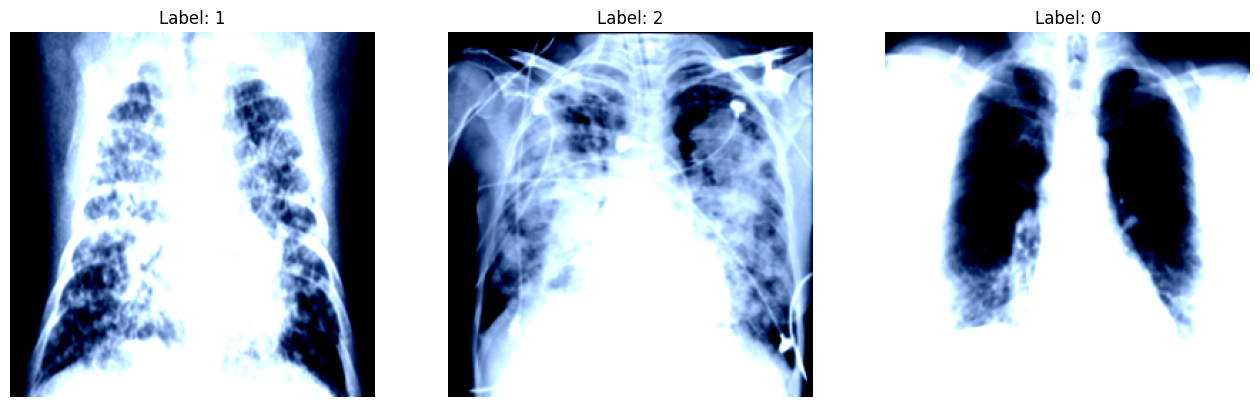

2026-01-20 13:51:05.865024: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
# Visualize a small batch to validate preprocessing and labels
for img, label in sub_train_dataset.take(1):
    fig, axes = plt.subplots(1, 3, figsize= (16, 9))
    for i, ax in enumerate(axes):
        ax.imshow(img[i].numpy())
        ax.set_title(f"Label: {tf.argmax(label[i])}")
        ax.axis("off")
    plt.show()

## Section 4 - Dataset Metadata & Class Weights for Optuna

Before starting hyperparameter optimization with Optuna, we compute **critical metadata** from the training dataset:

1. **Optuna Training Steps (`optuna_steps`)**  
   - Defines the number of steps per epoch for Optuna trials based on dataset size and batch size.  
   - Ensures consistency across trials.

2. **Class Weights (`weights` and `alpha_weights`)**  
   - Adjusts for class imbalance in the dataset.  
   - `weights` are raw counts per class; `alpha_weights` are normalized to sum to 1.  
   - Proper weighting prevents minority classes from being ignored during training.

3. **Validation Steps (`validation_steps`)**  
   - Number of batches in the validation dataset.  
   - Used for evaluation during Optuna trials.

**Professional Advantages:**  
- Makes training robust to class imbalance.  
- Ensures reproducible Optuna experiments.  
- Storing metadata in `ARCHITECTURE_CONFIG` keeps the pipeline **modular and transparent**.


In [20]:
# Compute Optuna dataset metadata
# --------------------------------
# optuna_metadata: dictionary with steps and weights extracted from the training dataset
# optuna_steps: number of training steps per epoch
# weights: absolute class counts
# alpha_weights: normalized weights for metrics or penalized F1 calculation
# validation_steps: number of steps in validation dataset
# Store steps into ARCHITECTURE_CONFIG for later use in Optuna trials

optuna_metadata = get_dataset_metadata(sub_train_dataset, GLOBAL_BATCH_SIZE)
optuna_steps = optuna_metadata["steps"]
weights = optuna_metadata["weights"]

# Convert class weights to numpy array for further calculations
weights = np.array([weights[k] for k in weights.keys()])

# Normalize weights to sum to 1
alpha_weights = (weights / weights.sum()).tolist()

# Count validation steps from validation dataset
validation_steps = count_steps_from_dataset(val_dataset)

# Print summary for reader visibility
print(f"Optuna Training Steps: {optuna_steps}\nValidation Steps: {validation_steps}")
print(f"Class weights: {weights}")
print(f"Alpha weights: {alpha_weights}")

# Save metadata into config for Optuna use
ARCHITECTURE_CONFIG['optuna_steps'] = int(optuna_steps)
ARCHITECTURE_CONFIG['validation_steps'] = int(validation_steps)

Optuna Training Steps: 411
Validation Steps: 131
Class weights: [1.0320151  2.781726   0.59825325]
Alpha weights: [0.23391126096248627, 0.6304917931556702, 0.13559702038764954]


---
## Section 5 - Model & Hyperparameter Utilities

This section defines the **core building blocks** for architecture search and model evaluation.

It includes:

1. **Hyperparameter generation (`architecture_hparams`)**  
   - Uses a **binary-like search with descending patterns** to reduce the search space.
   - Ensures professional balance between exploration and computation efficiency.

2. **DenseNet-based model factory (`densenet_model`)**  
   - Implements a **DenseNet121 backbone** with frozen weights for transfer learning.
   - Includes configurable head layers for classification.
   - DenseNet is widely used in **medical AI papers**, such as **CheXNet** for pneumonia detection, due to its feature reuse and strong gradient flow.

3. **Model compilation (`compile_model`)**  
   - Standardizes the optimizer, loss, and metric configuration.
   - Includes **F1, precision, recall, AUC** metrics critical for imbalanced medical datasets.

4. **Penalized F1 scoring (`penalized_f1_score`)**  
   - Calculates a **rolling window F1 score** with a **precision-recall gap penalty**.
   - Provides a **robust evaluation metric** for architecture ranking in Optuna.


### 5.1 Hyperparameter Sampling: `architecture_hparams`

- **Purpose:** Generate head classifier configurations for Optuna trials.  
- **Binary search + descending pattern:**  
  - Reduces combinatorial search space.  
  - Starts from a large first dense unit, then divides by 2 or 4 for deeper layers.  
  - Guarantees a **monotonically decreasing architecture**, avoiding redundant exploration of very large small layers.
- **Professional advantage:**  
  - Faster convergence in architecture search.  
  - Aligns with best practices in NAS (Neural Architecture Search) for classification heads.


In [38]:
def architecture_hparams(trial):
    """
    Generate a head classifier architecture for Optuna trials.

    Parameters
    ----------
    trial : optuna.trial.Trial
        Optuna trial object used to suggest hyperparameters.

    Returns
    -------
    dict
        Dictionary containing:
        - 'num_layers': Number of dense layers in the head
        - 'dense_units': List of units for each layer (descending pattern)
    """
    # Initialize hyperparameter dictionary
    hparams = {}
    
    # Number of dense layers in the classification head (1 to 3)
    hparams["num_layers"] = trial.suggest_int("num_layers", 1, 3)
    
    # First dense layer units (start large, will reduce in subsequent layers)
    first_unit = trial.suggest_categorical("first_unit", [256, 512, 1024])
    dense_units = [first_unit]
    
    # Subsequent layers: divide previous layer by 2 or 4 (descending pattern)
    # Reduces search space and encourages efficient architectures
    for i in range(1, hparams["num_layers"]):
        divide_by = trial.suggest_categorical(f"divide_{i}", [2, 4])
        next_unit = dense_units[-1] // divide_by
        next_unit = max(next_unit, 32)  # Ensure minimum size for stability
        dense_units.append(next_unit)
    
    # Store computed dense layer units in hyperparameter dict
    hparams["dense_units"] = dense_units
    return hparams

### 5.2 DenseNet121 Model Factory: `densenet_model`

- **Purpose:** Build a DenseNet-based transfer learning model with a configurable classification head.
- **DenseNet in Medical AI:**  
  - DenseNet121 is used in **CheXNet** and other medical imaging works for chest X-ray classification.  
  - Strengths: feature reuse, strong gradient flow, better generalization with fewer parameters.
- **Phase-specific dropout:**  
  - `'arch'` phase: only final head layer dropout for architecture search.  
  - `'opt'` phase: dropout applied to all head layers for hyperparameter tuning.
- **Input preprocessing:**  
  - Uses `preprocess_input` specific to DenseNet (expects images in `[0, 255]` with internal normalization).  
  - Ensures consistency with pretrained weights.


In [39]:
def densenet_model(
    hparams, dropout_rate,
    config=MODEL_CONFIG, phase=None
):
    """
    Build a DenseNet121 model with a configurable classification head.

    Parameters
    ----------
    hparams : dict
        Dictionary containing head architecture ('num_layers' and 'dense_units').
    dropout_rate : float
        Dropout rate applied to the head layers.
    config : dict
        Model configuration dictionary (image size, num_classes).
    phase : str, optional
        Phase of training: 'arch' for architecture search, 'opt' for hyperparameter tuning.

    Returns
    -------
    tf.keras.Model
        Keras model ready for training.
    """
    # Extract image size and number of classes from config
    img_size = MODEL_CONFIG["img_size"]
    num_classes = MODEL_CONFIG["num_classes"]
    
    # Input layer
    inputs = tfl.Input(shape= img_size + (3,))
    
    # DenseNet121 backbone, pretrained on ImageNet
    base_model = DenseNet121(
        name= 'densenet',
        weights= 'imagenet',
        include_top= False
    )
    
    # Freeze all layers for transfer learning
    base_model.trainable = False
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False  # Keep batch norm layers frozen

    # Extract features from backbone
    densenet = base_model(inputs, training= False)
    x = tfl.GlobalAveragePooling2D()(densenet)  # Global pooling to flatten features
    
    # Add head layers based on hyperparameters
    num_dense_layers = hparams["num_layers"]
    for i in range(num_dense_layers):
        units = hparams["dense_units"][i]
        x = tfl.Dense(units, activation= 'relu', name=f"head_dense_{i}")(x)
        
        # Apply dropout differently depending on phase
        if phase == 'arch':
            if i == num_dense_layers - 1:
                head_dropout = tfl.Dropout(dropout_rate, name="head_dropout")
                x = head_dropout(x, training=True)
        elif phase == 'opt':
            dropout = tfl.Dropout(dropout_rate, name=f"dropout_{i}")
            x = dropout(x, training=True)
        else:
            print(f"Unknown phase! arch or opt!")

    # Final output layer
    outputs = tfl.Dense(num_classes, activation= 'softmax')(x)
    
    # Create model
    model = tf.keras.Model(inputs, outputs)
    
    return model

### 5.3 Model Compilation: `compile_model`

- **Purpose:** Standardize the optimizer, loss, and evaluation metrics.  
- **Metrics included:**  
  - `CategoricalAccuracy`, `Precision`, `Recall`, `F1Score`, `AUC`  
  - Important for imbalanced datasets like medical images.
- **Professional advantage:**  
  - Ensures consistent evaluation across trials.  
  - Simplifies swapping optimizers or losses for hyperparameter tuning.


In [40]:
def compile_model(model, loss, optimizer):
    """
    Compile a Keras model with standardized loss and metrics.

    Parameters
    ----------
    model : tf.keras.Model
        Keras model to compile.
    loss : tf.keras.losses.Loss
        Loss function to use (e.g., CategoricalCrossentropy).
    optimizer : tf.keras.optimizers.Optimizer
        Optimizer to use (e.g., Adam).

    Returns
    -------
    tf.keras.Model
        Compiled Keras model with specified loss and metrics.
    """
    # Compile the model with provided loss and optimizer
    # Metrics chosen to handle imbalanced medical datasets
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.metrics.F1Score(name="f1_score", average="macro"),
            tf.metrics.AUC(name='AUC')
        ],
    )
    return model

### 5.4 Penalized F1 Score: `penalized_f1_score`

- **Purpose:** Evaluate the architecture using a robust F1-based metric.  
- **Rolling window average:** Smooths noisy epoch-level metrics.  
- **Precision-Recall Gap Penalty (`alpha_p`)**: Penalizes models with unbalanced precision vs recall.  
- **Stage epochs (`stage_arch`)**: Allows flexible evaluation even in short training runs.  
- **Professional advantage:**  
  - Provides a **single scalar** for Optuna to maximize.  
  - Reduces metric noise and encourages balanced performance across classes.


In [41]:
def penalized_f1_score(history, config=PENALIZED_F1_CONFIG):
    """
    Calculate a rolling-window penalized F1 score for architecture evaluation.

    Parameters
    ----------
    history : tf.keras.callbacks.History
        Keras history object returned from model.fit().
    config : dict, optional
        Configuration dictionary containing:
        - 'K_arch': rolling window size
        - 'alpha_p': penalty factor for precision-recall gap
        - 'stage_arch': number of epochs to consider from the end

    Returns
    -------
    tuple
        - score : float, penalized F1 used for Optuna optimization
        - f1 : float, raw F1 score at best epoch
        - prec : float, precision at best epoch
        - rec : float, recall at best epoch
    """
    # Extract rolling window size, penalty, and number of epochs
    K = config['K_arch']
    alpha_p = config['alpha_p']
    stage_epochs = config['stage_arch']

    # Retrieve validation metrics
    val_f1 = np.array(history.history["val_f1_score"])
    val_prec = np.array(history.history["val_precision"])
    val_rec = np.array(history.history["val_recall"])
    
    # Adaptive window if training was shorter than expected
    stage_epochs = min(stage_epochs, len(val_f1))
    
    # Rolling average to smooth fluctuations
    f1_roll = np.convolve(val_f1[-stage_epochs:], np.ones(K)/K, mode="valid")
    prec_roll = np.convolve(val_prec[-stage_epochs:], np.ones(K)/K, mode="valid")
    rec_roll = np.convolve(val_rec[-stage_epochs:], np.ones(K)/K, mode="valid")
    
    # Identify best epoch by F1
    idx = np.argmax(f1_roll)
    f1 = f1_roll[idx]
    prec = prec_roll[idx]
    rec = rec_roll[idx]
    
    # Apply precision-recall gap penalty
    gap_penalty = alpha_p * abs(prec - rec)
    score = f1 - gap_penalty
    
    return score, f1, prec, rec

## Section 6 - Optuna Architecture Optimization

<div style="text-align: center;">
    <img src="../../images/optuna_process.png" alt="Crop with image and mask" style="display: block; margin: 0 auto;">
</div>

---
---
In this section, we perform the **core hyperparameter optimization** for our DenseNet-based head classifier using **Optuna**.  
Optuna is a powerful, flexible, and professional hyperparameter optimization framework widely used in **Medical AI** and deep learning projects.

---

### **Why Optuna?**

Optuna allows us to:

- **Automate hyperparameter search** across large and complex search spaces.
- **Use pruning** to stop unpromising trials early, saving GPU and time.
- **Store results** in a persistent database (here: SQLite) for reproducibility.
- **Track multiple metrics** and custom objectives (like penalized F1).
- Support both **architecture search** (number of layers, units) and **optimization search** (learning rate, dropout, weight decay) in separate phases.

Professionals use Optuna in medical AI for **reproducible architecture and training optimization**, especially when datasets are small, imbalanced, or computationally expensive to train.

---

### **Trial Objective Function**

The `objective_architecture(trial)` function is the **heart of Optuna trials**:

1. Receives a `trial` object to **suggest hyperparameters** (like number of layers, units per layer).  
2. Builds a **DenseNet121 backbone** model with the suggested head classifier.  
3. Compiles the model with **Categorical Crossentropy** and **Adam optimizer**.  
4. Trains the model on the **training dataset** and validates on **validation dataset**.  
5. Evaluates performance using a **penalized F1 score** to balance precision and recall.  
6. Returns the penalized F1 as the **objective to maximize**.

---

### **Distributed Training and Memory Management**

- Uses `strategy.scope()` to leverage **multi-GPU / distributed training**.  
- After each trial, `cleanup(model, history, callbacks)` ensures **GPU memory is freed**.  
- `gc_after_trial=True` further guarantees **no memory leaks** during Optuna optimization.

---

### **Persistent Study and Metadata**

- Optuna stores trials in a **SQLite database**, allowing **resuming previous runs** and keeping all trial information.  
- After completing the search, we extract the **best trial hyperparameters** and save them along with **training settings and timestamps**.  
- This ensures **full reproducibility** for subsequent training or Phase 2 optimization.

---

### **Key Advantages for Professionals**

- Automates **architecture + hyperparameter search**.
- Reduces human error in tuning deep learning models.
- Pruning and persistent studies save **time and resources**.
- Allows **custom objective functions** (like penalized F1) to better match domain-specific metrics.
- Widely adopted in **Medical AI research papers**, especially for tasks like **lung disease classification**, **X-ray analysis**, and **COVID-19 detection**.


### 6.1 Trial Objective Function**

The `objective_architecture(trial)` function defines the **objective for each Optuna trial**.  

**Key points:**

- Receives a `trial` object from Optuna to **suggest hyperparameters** (like `num_layers` or `dense_units` in the head classifier).  
- Builds a **DenseNet121 backbone** model with the suggested architecture and dropout.  
- Compiles the model with **Categorical Crossentropy** and **Adam optimizer**.  
- Trains the model on the **training dataset** and validates on **validation dataset**.  
- Computes the **penalized F1 score**, which is returned as the **objective to maximize**.  

**Professional Note:**  
Using a **custom objective function** like penalized F1 ensures that the model is optimized for metrics that are **relevant to the task**, especially in **imbalanced medical datasets**.

In [42]:
def objective_architecture(trial, config=ARCHITECTURE_CONFIG):
    """
    Objective function for Optuna architecture search.

    This function defines the training and evaluation procedure for a single Optuna trial.
    It builds a DenseNet-based model with a head classifier configuration suggested
    by the trial, compiles it, trains it on the dataset, and evaluates it using a
    penalized F1 score.

    Parameters
    ----------
    trial : optuna.trial.Trial
        Optuna trial object used to suggest hyperparameters for the head classifier.
    config : dict
        Configuration dictionary containing architecture search settings:
        - 'arch_epoch': number of epochs to train each trial
        - 'optuna_steps': steps per epoch
        - 'validation_steps': validation steps

    Returns
    -------
    float
        Penalized F1 score used by Optuna to rank the trial.
    """
    # Divider for console output
    print("="*60)
    print(f"Trial {trial.number + 1}/{config['arch_trials']} started...")

    # Extract relevant configuration values
    arch_epoch = config['arch_epoch']
    optuna_steps = config['optuna_steps']
    validation_steps = config['validation_steps']

    model = None
    history = None
    callbacks = None
    lr = 3e-4  # Fixed learning rate for architecture search

    try:
        # Use distributed strategy if available
        with strategy.scope():
            # Standard loss and optimizer
            loss = tf.keras.losses.CategoricalCrossentropy()
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            
            # Generate head architecture for this trial
            arch_hparams = architecture_hparams(trial)
            trial.set_user_attr("arch_hparams", arch_hparams)

            # Build model with suggested architecture
            model = densenet_model(
                arch_hparams, dropout_rate=0.1, config=MODEL_CONFIG, phase='arch'
            )

            # Compile the model
            model = compile_model(model, loss=loss, optimzier=optimizer)

        # Train the model on the dataset
        history = model.fit(
            sub_train_dataset.repeat(),
            validation_data=val_dataset.repeat(),
            epochs=arch_epoch,
            steps_per_epoch=optuna_steps,
            validation_steps=validation_steps
        )

        # Evaluate performance using penalized F1
        score, best_f1, best_prec, best_rec = penalized_f1_score(
            history, config=PENALIZED_F1_CONFIG
        )
        trial.set_user_attr("phase1_score", float(score))

        # Print summary of metrics for this trial
        print(f"Penalized F1: {score:.4f}, Best F1: {best_f1:.4f}, "
              f"P: {best_prec:.4f}, R: {best_rec:.4f}")

        # Return penalized F1 to Optuna for trial ranking
        return score

    finally:
        # Clean up resources to avoid memory leaks
        cleanup(model, history, callbacks)

### 6.2 Optuna Study & Metadata

After defining the objective function:

1. An **Optuna study** is created to maximize the penalized F1.  
2. **Trials are persisted** in an SQLite database (`storage_dir`) to allow resuming optimization later.  
3. The **best trial** is extracted and its hyperparameters stored in a `metadata` dictionary.  
4. The metadata includes **trial number, best F1 score, architecture settings, optimizer, dropout, learning rate, timestamp, and seed**.  

**Professional Advantages:**

- Ensures **reproducibility** for future experiments.  
- Provides **audit trails** for model architecture selection.  
- Allows seamless continuation if the optimization is **interrupted**.


In [38]:
# --- Optuna Study Creation ---
# Create a persistent study to store trial results in a SQLite database
storage_dir = "sqlite:///phase1_architecture/diseases-phase1_architecture.db"
study = optuna.create_study(
    direction='maximize',  # Objective: maximize penalized F1
    storage=storage_dir,
    load_if_exists=True   # Continue previous study if it exists
)

# Run the optimization process for a fixed number of trials
study.optimize(
    lambda trial: objective_architecture(trial, config=ARCHITECTURE_CONFIG),
    n_trials=ARCHITECTURE_CONFIG['arch_trials'],
    gc_after_trial=True   # Force garbage collection to free GPU memory
)

# --- Extract best trial hyperparameters ---
best_trial = study.best_trial
best_hparams = best_trial.user_attrs.get("arch_hparams", None)

# If dense_units are not stored, reconstruct them from trial params
if best_hparams is None:
    params = best_trial.params
    num_layers = params["num_layers"]
    first_unit = int(params["first_unit"])
    dense_units = [first_unit]
    for i in range(1, num_layers):
        divide_by = int(params[f"divide_{i}"])
        dense_units.append(max(dense_units[-1] // divide_by, 32))
    best_hparams = {
        "num_layers": num_layers,
        "dense_units": dense_units,
    }

# --- Save phase 1 metadata for reproducibility ---
metadata = {
    "best_trial_number": int(best_trial.number),
    "best_value": float(best_trial.value),
    "best_hparams": best_hparams,
    "phase1_settings": {
        "loss": "CategoricalCrossentropy",
        "optimizer": "Adam",
        "lr": 3e-4,
        "weight_decay": 0,
        "dropout_rate": 0.1
    },
    "timestamp": time.time(),
    "seed": SEED
}

metadata_dir = "./phase1_architecture/diseases-best_architecture.json"
with open(metadata_dir, "w") as f:
    json.dump(metadata, f, indent=2)

[I 2026-01-05 17:18:44,401] A new study created in RDB with name: no-name-9fa5c681-4dd5-457c-9033-20f57c502766


Trial 1/20 started...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',)

2026-01-05 17:18:55.849306: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2026-01-05 17:18:57.176424: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


411/411 ━━━━━━━━━━━━━━━━━━━━ 67s 139ms/step - AUC: 0.9307 - accuracy: 0.7856 - f1_score: 0.7962 - loss: 0.4896 - precision: 0.7958 - recall: 0.7631 - val_AUC: 0.9541 - val_accuracy: 0.8082 - val_f1_score: 0.8179 - val_loss: 0.4036 - val_precision: 0.8105 - val_recall: 0.8082
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 132ms/step - AUC: 0.9727 - accuracy: 0.8786 - f1_score: 0.8931 - loss: 0.3053 - precision: 0.8809 - recall: 0.8753 - val_AUC: 0.9812 - val_accuracy: 0.8969 - val_f1_score: 0.9146 - val_loss: 0.2514 - val_precision: 0.8983 - val_recall: 0.8931
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9799 - accuracy: 0.8939 - f1_score: 0.9073 - loss: 0.2607 - precision: 0.8951 - recall: 0.8905 - val_AUC: 0.9820 - val_accuracy: 0.8941 - val_f1_score: 0.9136 - val_loss: 0.2484 - val_precision: 0.8941 - val_recall: 0.8941
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9843 - accuracy: 0.9027 - f1_score: 0.9159 - loss: 0.2308 - precision: 0.9031 - recall: 0

[I 2026-01-05 17:25:25,619] Trial 0 finished with value: 0.9190078794956207 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 4}. Best is trial 0 with value: 0.9190078794956207.


Trial 2/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - AUC: 0.8864 - accuracy: 0.7198 - f1_score: 0.7083 - loss: 0.6088 - precision: 0.7346 - recall: 0.6875

2026-01-05 17:26:18.019521: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2026-01-05 17:26:18.033030: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


411/411 ━━━━━━━━━━━━━━━━━━━━ 62s 141ms/step - AUC: 0.9324 - accuracy: 0.7838 - f1_score: 0.7949 - loss: 0.4808 - precision: 0.7955 - recall: 0.7679 - val_AUC: 0.9691 - val_accuracy: 0.8473 - val_f1_score: 0.8569 - val_loss: 0.3311 - val_precision: 0.8548 - val_recall: 0.8426
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 132ms/step - AUC: 0.9707 - accuracy: 0.8650 - f1_score: 0.8805 - loss: 0.3156 - precision: 0.8676 - recall: 0.8610 - val_AUC: 0.9806 - val_accuracy: 0.8950 - val_f1_score: 0.9147 - val_loss: 0.2662 - val_precision: 0.8967 - val_recall: 0.8941
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 131ms/step - AUC: 0.9816 - accuracy: 0.8987 - f1_score: 0.9114 - loss: 0.2493 - precision: 0.9016 - recall: 0.8972 - val_AUC: 0.9820 - val_accuracy: 0.9008 - val_f1_score: 0.9189 - val_loss: 0.2464 - val_precision: 0.9024 - val_recall: 0.8998
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 132ms/step - AUC: 0.9840 - accuracy: 0.9078 - f1_score: 0.9205 - loss: 0.2308 - precision: 0.9088 - recall: 0

[I 2026-01-05 17:31:59,843] Trial 1 finished with value: 0.9220114946365356 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 4}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3303.02 MB
Trial 3/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - AUC: 0.8978 - accuracy: 0.7425 - f1_score: 0.7412 - loss: 0.5695 - precision: 0.7548 - recall: 0.7206

2026-01-05 17:32:51.854046: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']


411/411 ━━━━━━━━━━━━━━━━━━━━ 62s 139ms/step - AUC: 0.9456 - accuracy: 0.8108 - f1_score: 0.8202 - loss: 0.4324 - precision: 0.8190 - recall: 0.8011 - val_AUC: 0.9754 - val_accuracy: 0.8779 - val_f1_score: 0.8914 - val_loss: 0.2922 - val_precision: 0.8798 - val_recall: 0.8731
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 131ms/step - AUC: 0.9752 - accuracy: 0.8771 - f1_score: 0.8916 - loss: 0.2888 - precision: 0.8790 - recall: 0.8750 - val_AUC: 0.9759 - val_accuracy: 0.8693 - val_f1_score: 0.8791 - val_loss: 0.2883 - val_precision: 0.8714 - val_recall: 0.8664
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9815 - accuracy: 0.8951 - f1_score: 0.9086 - loss: 0.2486 - precision: 0.8956 - recall: 0.8926 - val_AUC: 0.9748 - val_accuracy: 0.8693 - val_f1_score: 0.8851 - val_loss: 0.2963 - val_precision: 0.8718 - val_recall: 0.8693
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 131ms/step - AUC: 0.9859 - accuracy: 0.9103 - f1_score: 0.9237 - loss: 0.2163 - precision: 0.9115 - recall: 0

[I 2026-01-05 17:38:32,978] Trial 2 finished with value: 0.912194111943245 and parameters: {'num_layers': 1, 'first_unit': 512}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3380.25 MB
Trial 4/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 141ms/step - AUC: 0.9361 - accuracy: 0.7859 - f1_score: 0.7984 - loss: 0.4666 - precision: 0.7933 - recall: 0.7716 - val_AUC: 0.9723 - val_accuracy: 0.8683 - val_f1_score: 0.8857 - val_loss: 0.3120 - val_precision: 0.8686 - val_recall: 0.8645
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9748 - accuracy: 0.8738 - f1_score: 0.8871 - loss: 0.2948 - precision: 0.8773 - recall: 0.8717 - val_AUC: 0.9796 - val_accuracy: 0.8893 - val_f1_score: 0.9057 - val_loss: 0.2655 - val_precision: 0.8921 - val_recall: 0.8836
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - AUC: 0.9812 - accuracy: 0.8991 - f1_score: 0.9122 - loss: 0.2528 - precision: 0.9014 - recall: 0.8970

2026-01-05 17:41:17.926212: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: Function was cancelled before it was started
	 [[{{node RemoteCall}}]]


411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 131ms/step - AUC: 0.9820 - accuracy: 0.9024 - f1_score: 0.9158 - loss: 0.2467 - precision: 0.9044 - recall: 0.9002 - val_AUC: 0.9789 - val_accuracy: 0.8865 - val_f1_score: 0.9059 - val_loss: 0.2667 - val_precision: 0.8907 - val_recall: 0.8865
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - AUC: 0.9839 - accuracy: 0.9045 - f1_score: 0.9171 - loss: 0.2337 - precision: 0.9059 - recall: 0.9042 - val_AUC: 0.9832 - val_accuracy: 0.9008 - val_f1_score: 0.9171 - val_loss: 0.2373 - val_precision: 0.9006 - val_recall: 0.8989
Epoch 5/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9879 - accuracy: 0.9148 - f1_score: 0.9272 - loss: 0.2044 - precision: 0.9156 - recall: 0.9139 - val_AUC: 0.9826 - val_accuracy: 0.8960 - val_f1_score: 0.9083 - val_loss: 0.2441 - val_precision: 0.8976 - val_recall: 0.8950
Epoch 6/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 132ms/step - AUC: 0.9887 - accuracy: 0.9218 - f1_score: 0.9322 - loss: 0.1955 - precision: 0.9226 - recall: 0

[I 2026-01-05 17:45:19,229] Trial 3 finished with value: 0.9169347554445266 and parameters: {'num_layers': 1, 'first_unit': 256}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3465.79 MB
Trial 5/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step - AUC: 0.9468 - accuracy: 0.8114 - f1_score: 0.8260 - loss: 0.4259 - precision: 0.8191 - recall: 0.8044 - val_AUC: 0.9767 - val_accuracy: 0.8712 - val_f1_score: 0.8878 - val_loss: 0.2830 - val_precision: 0.8718 - val_recall: 0.8693
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 133ms/step - AUC: 0.9764 - accuracy: 0.8853 - f1_score: 0.8989 - loss: 0.2817 - precision: 0.8870 - recall: 0.8835 - val_AUC: 0.9786 - val_accuracy: 0.8912 - val_f1_score: 0.9077 - val_loss: 0.2676 - val_precision: 0.8937 - val_recall: 0.8903
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 132ms/step - AUC: 0.9817 - accuracy: 0.8957 - f1_score: 0.9095 - loss: 0.2471 - precision: 0.8980 - recall: 0.8948 - val_AUC: 0.9803 - val_accuracy: 0.8941 - val_f1_score: 0.9135 - val_loss: 0.2567 - val_precision: 0.8958 - val_recall: 0.8941
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 131ms/step - AUC: 0.9863 - accuracy:

[I 2026-01-05 17:51:55,109] Trial 4 finished with value: 0.9161755532026291 and parameters: {'num_layers': 1, 'first_unit': 512}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3517.27 MB
Trial 6/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 139ms/step - AUC: 0.9452 - accuracy: 0.8054 - f1_score: 0.8196 - loss: 0.4328 - precision: 0.8146 - recall: 0.7990 - val_AUC: 0.9769 - val_accuracy: 0.8750 - val_f1_score: 0.8885 - val_loss: 0.2833 - val_precision: 0.8776 - val_recall: 0.8693
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9777 - accuracy: 0.8838 - f1_score: 0.8975 - loss: 0.2734 - precision: 0.8862 - recall: 0.8814 - val_AUC: 0.9826 - val_accuracy: 0.8960 - val_f1_score: 0.9126 - val_loss: 0.2432 - val_precision: 0.8966 - val_recall: 0.8931
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9838 - accuracy: 0.9015 - f1_score: 0.9127 - loss: 0.2341 - precision: 0.9042 - recall: 0.9015 - val_AUC: 0.9744 - val_accuracy: 0.8721 - val_f1_score: 0.8865 - val_loss: 0.3001 - val_precision: 0.8730 - val_recall: 0.8721
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9853 - accuracy:

[I 2026-01-05 17:58:31,942] Trial 5 finished with value: 0.8952729284763337 and parameters: {'num_layers': 1, 'first_unit': 1024}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3581.92 MB
Trial 7/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step - AUC: 0.9304 - accuracy: 0.7838 - f1_score: 0.7916 - loss: 0.4901 - precision: 0.7988 - recall: 0.7536 - val_AUC: 0.9742 - val_accuracy: 0.8817 - val_f1_score: 0.9016 - val_loss: 0.2989 - val_precision: 0.8823 - val_recall: 0.8798
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9694 - accuracy: 0.8656 - f1_score: 0.8795 - loss: 0.3208 - precision: 0.8687 - recall: 0.8634 - val_AUC: 0.9781 - val_accuracy: 0.8874 - val_f1_score: 0.9090 - val_loss: 0.2729 - val_precision: 0.8891 - val_recall: 0.8874
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9792 - accuracy: 0.8899 - f1_score: 0.9047 - loss: 0.2632 - precision: 0.8916 - recall: 0.8878 - val_AUC: 0.9819 - val_accuracy: 0.8931 - val_f1_score: 0.9134 - val_loss: 0.2453 - val_precision: 0.8931 - val_recall: 0.8931
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9846 - accuracy:

[I 2026-01-05 18:05:19,235] Trial 6 finished with value: 0.9188609957695008 and parameters: {'num_layers': 3, 'first_unit': 256, 'divide_1': 4, 'divide_2': 4}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3628.25 MB
Trial 8/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 141ms/step - AUC: 0.9462 - accuracy: 0.8066 - f1_score: 0.8204 - loss: 0.4296 - precision: 0.8147 - recall: 0.7981 - val_AUC: 0.9776 - val_accuracy: 0.8826 - val_f1_score: 0.9039 - val_loss: 0.2813 - val_precision: 0.8834 - val_recall: 0.8817
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9756 - accuracy: 0.8820 - f1_score: 0.8957 - loss: 0.2858 - precision: 0.8828 - recall: 0.8796 - val_AUC: 0.9622 - val_accuracy: 0.8502 - val_f1_score: 0.8790 - val_loss: 0.3640 - val_precision: 0.8538 - val_recall: 0.8473
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9802 - accuracy: 0.8881 - f1_score: 0.9021 - loss: 0.2578 - precision: 0.8895 - recall: 0.8866 - val_AUC: 0.9798 - val_accuracy: 0.8903 - val_f1_score: 0.9057 - val_loss: 0.2599 - val_precision: 0.8902 - val_recall: 0.8893
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 132ms/step - AUC: 0.9864 - accuracy:

[I 2026-01-05 18:11:57,215] Trial 7 finished with value: 0.9187465667724609 and parameters: {'num_layers': 1, 'first_unit': 1024}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3698.36 MB
Trial 9/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step - AUC: 0.9407 - accuracy: 0.8014 - f1_score: 0.8151 - loss: 0.4526 - precision: 0.8109 - recall: 0.7862 - val_AUC: 0.9698 - val_accuracy: 0.8588 - val_f1_score: 0.8720 - val_loss: 0.3180 - val_precision: 0.8599 - val_recall: 0.8550
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9752 - accuracy: 0.8805 - f1_score: 0.8942 - loss: 0.2878 - precision: 0.8821 - recall: 0.8786 - val_AUC: 0.9682 - val_accuracy: 0.8607 - val_f1_score: 0.8745 - val_loss: 0.3341 - val_precision: 0.8607 - val_recall: 0.8607
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9829 - accuracy: 0.9021 - f1_score: 0.9132 - loss: 0.2389 - precision: 0.9049 - recall: 0.9002 - val_AUC: 0.9804 - val_accuracy: 0.8912 - val_f1_score: 0.9060 - val_loss: 0.2593 - val_precision: 0.8920 - val_recall: 0.8903
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9861 - accuracy:

[I 2026-01-05 18:18:36,651] Trial 8 finished with value: 0.919568333029747 and parameters: {'num_layers': 2, 'first_unit': 512, 'divide_1': 4}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3728.09 MB
Trial 10/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 140ms/step - AUC: 0.9410 - accuracy: 0.8014 - f1_score: 0.8097 - loss: 0.4501 - precision: 0.8088 - recall: 0.7847 - val_AUC: 0.9788 - val_accuracy: 0.8750 - val_f1_score: 0.8951 - val_loss: 0.2887 - val_precision: 0.8809 - val_recall: 0.8750
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9744 - accuracy: 0.8771 - f1_score: 0.8913 - loss: 0.2960 - precision: 0.8784 - recall: 0.8726 - val_AUC: 0.9820 - val_accuracy: 0.8826 - val_f1_score: 0.9031 - val_loss: 0.2514 - val_precision: 0.8842 - val_recall: 0.8817
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 54s 132ms/step - AUC: 0.9809 - accuracy: 0.8975 - f1_score: 0.9109 - loss: 0.2538 - precision: 0.8990 - recall: 0.8960 - val_AUC: 0.9832 - val_accuracy: 0.8941 - val_f1_score: 0.9118 - val_loss: 0.2401 - val_precision: 0.8949 - val_recall: 0.8941
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9857 - accuracy

[I 2026-01-05 18:25:15,160] Trial 9 finished with value: 0.9202259451150894 and parameters: {'num_layers': 1, 'first_unit': 256}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3819.71 MB
Trial 11/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - AUC: 0.8919 - accuracy: 0.7381 - f1_score: 0.6993 - loss: 0.6033 - precision: 0.7509 - recall: 0.6846

2026-01-05 18:26:09.558559: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 141ms/step - AUC: 0.9328 - accuracy: 0.7917 - f1_score: 0.7969 - loss: 0.4828 - precision: 0.8032 - recall: 0.7670 - val_AUC: 0.9273 - val_accuracy: 0.7290 - val_f1_score: 0.7102 - val_loss: 0.6402 - val_precision: 0.7311 - val_recall: 0.7290
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - AUC: 0.9720 - accuracy: 0.8720 - f1_score: 0.8854 - loss: 0.3079 - precision: 0.8733 - recall: 0.8677 - val_AUC: 0.9698 - val_accuracy: 0.8540 - val_f1_score: 0.8700 - val_loss: 0.3294 - val_precision: 0.8537 - val_recall: 0.8521
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9821 - accuracy: 0.8963 - f1_score: 0.9100 - loss: 0.2463 - precision: 0.8984 - recall: 0.8932 - val_AUC: 0.9654 - val_accuracy: 0.8454 - val_f1_score: 0.8779 - val_loss: 0.3549 - val_precision: 0.8470 - val_recall: 0.8397
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9824 - accuracy: 0.9033 - f1_score: 0.9170 - loss: 0.2420 - precision: 0.9059 - recall: 0

[I 2026-01-05 18:31:57,416] Trial 10 finished with value: 0.9127314478158951 and parameters: {'num_layers': 3, 'first_unit': 256, 'divide_1': 2, 'divide_2': 2}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3889.64 MB
Trial 12/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 141ms/step - AUC: 0.9395 - accuracy: 0.7974 - f1_score: 0.8058 - loss: 0.4571 - precision: 0.8086 - recall: 0.7786 - val_AUC: 0.9654 - val_accuracy: 0.8588 - val_f1_score: 0.8851 - val_loss: 0.3423 - val_precision: 0.8602 - val_recall: 0.8511
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9730 - accuracy: 0.8753 - f1_score: 0.8889 - loss: 0.3027 - precision: 0.8774 - recall: 0.8729 - val_AUC: 0.9804 - val_accuracy: 0.8969 - val_f1_score: 0.9143 - val_loss: 0.2601 - val_precision: 0.8992 - val_recall: 0.8941
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - AUC: 0.9817 - accuracy: 0.8948 - f1_score: 0.9090 - loss: 0.2482 - precision: 0.8955 - recall: 0.8942 - val_AUC: 0.9643 - val_accuracy: 0.8454 - val_f1_score: 0.8738 - val_loss: 0.3475 - val_precision: 0.8500 - val_recall: 0.8435
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9843 - accuracy

[I 2026-01-05 18:38:39,844] Trial 11 finished with value: 0.8946144700050354 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 2}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3958.66 MB
Trial 13/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 142ms/step - AUC: 0.9384 - accuracy: 0.7941 - f1_score: 0.8040 - loss: 0.4600 - precision: 0.8024 - recall: 0.7783 - val_AUC: 0.9649 - val_accuracy: 0.8464 - val_f1_score: 0.8585 - val_loss: 0.3498 - val_precision: 0.8488 - val_recall: 0.8464
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9730 - accuracy: 0.8765 - f1_score: 0.8911 - loss: 0.3024 - precision: 0.8787 - recall: 0.8726 - val_AUC: 0.9807 - val_accuracy: 0.8884 - val_f1_score: 0.9060 - val_loss: 0.2593 - val_precision: 0.8924 - val_recall: 0.8865
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9809 - accuracy: 0.8966 - f1_score: 0.9098 - loss: 0.2536 - precision: 0.8989 - recall: 0.8951 - val_AUC: 0.9825 - val_accuracy: 0.9046 - val_f1_score: 0.9224 - val_loss: 0.2485 - val_precision: 0.9052 - val_recall: 0.9017
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9831 - accuracy

[I 2026-01-05 18:45:22,734] Trial 12 finished with value: 0.9097271144390107 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 4}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 3976.40 MB
Trial 14/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 141ms/step - AUC: 0.9338 - accuracy: 0.7841 - f1_score: 0.7910 - loss: 0.4799 - precision: 0.7942 - recall: 0.7676 - val_AUC: 0.9746 - val_accuracy: 0.8721 - val_f1_score: 0.8873 - val_loss: 0.3045 - val_precision: 0.8763 - val_recall: 0.8655
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - AUC: 0.9699 - accuracy: 0.8613 - f1_score: 0.8758 - loss: 0.3194 - precision: 0.8634 - recall: 0.8577 - val_AUC: 0.9729 - val_accuracy: 0.8626 - val_f1_score: 0.8795 - val_loss: 0.3045 - val_precision: 0.8633 - val_recall: 0.8616
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9793 - accuracy: 0.8945 - f1_score: 0.9075 - loss: 0.2649 - precision: 0.8965 - recall: 0.8926 - val_AUC: 0.9829 - val_accuracy: 0.8989 - val_f1_score: 0.9165 - val_loss: 0.2384 - val_precision: 0.8989 - val_recall: 0.8989
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9836 - accuracy

[I 2026-01-05 18:52:13,856] Trial 13 finished with value: 0.9144665449857712 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 4}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 4091.81 MB
Trial 15/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 63s 141ms/step - AUC: 0.9367 - accuracy: 0.7938 - f1_score: 0.8046 - loss: 0.4711 - precision: 0.8152 - recall: 0.7634 - val_AUC: 0.9753 - val_accuracy: 0.8779 - val_f1_score: 0.8927 - val_loss: 0.2972 - val_precision: 0.8812 - val_recall: 0.8702
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - AUC: 0.9715 - accuracy: 0.8765 - f1_score: 0.8892 - loss: 0.3104 - precision: 0.8788 - recall: 0.8729 - val_AUC: 0.9795 - val_accuracy: 0.8874 - val_f1_score: 0.9071 - val_loss: 0.2666 - val_precision: 0.8877 - val_recall: 0.8826
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9795 - accuracy: 0.8966 - f1_score: 0.9074 - loss: 0.2632 - precision: 0.8972 - recall: 0.8948 - val_AUC: 0.9825 - val_accuracy: 0.9017 - val_f1_score: 0.9196 - val_loss: 0.2448 - val_precision: 0.9033 - val_recall: 0.8998
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9821 - accuracy

[I 2026-01-05 18:58:57,703] Trial 14 finished with value: 0.9170680820941925 and parameters: {'num_layers': 3, 'first_unit': 256, 'divide_1': 2, 'divide_2': 4}. Best is trial 1 with value: 0.9220114946365356.


Trial 16/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 141ms/step - AUC: 0.9496 - accuracy: 0.8181 - f1_score: 0.8299 - loss: 0.4161 - precision: 0.8249 - recall: 0.8096 - val_AUC: 0.9762 - val_accuracy: 0.8740 - val_f1_score: 0.8914 - val_loss: 0.2826 - val_precision: 0.8749 - val_recall: 0.8740
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9719 - accuracy: 0.8726 - f1_score: 0.8880 - loss: 0.3071 - precision: 0.8747 - recall: 0.8707 - val_AUC: 0.9808 - val_accuracy: 0.8979 - val_f1_score: 0.9107 - val_loss: 0.2570 - val_precision: 0.8990 - val_recall: 0.8922
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - AUC: 0.9842 - accuracy: 0.9082 - f1_score: 0.9196 - loss: 0.2299 - precision: 0.9091 - recall: 0.9069 - val_AUC: 0.9803 - val_accuracy: 0.8998 - val_f1_score: 0.9102 - val_loss: 0.2603 - val_precision: 0.9000 - val_recall: 0.8931
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9858 - accuracy: 0.9072 - f1_score: 0.9206 - loss: 0.216

[I 2026-01-05 19:05:39,149] Trial 15 finished with value: 0.9111027538776397 and parameters: {'num_layers': 1, 'first_unit': 1024}. Best is trial 1 with value: 0.9220114946365356.


🧹 RAM Cleaned. Current usage: 4224.45 MB
Trial 17/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 142ms/step - AUC: 0.9317 - accuracy: 0.7774 - f1_score: 0.7814 - loss: 0.4888 - precision: 0.7894 - recall: 0.7503 - val_AUC: 0.9717 - val_accuracy: 0.8626 - val_f1_score: 0.8753 - val_loss: 0.3156 - val_precision: 0.8667 - val_recall: 0.8559
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - AUC: 0.9717 - accuracy: 0.8744 - f1_score: 0.8868 - loss: 0.3101 - precision: 0.8770 - recall: 0.8695 - val_AUC: 0.9690 - val_accuracy: 0.8626 - val_f1_score: 0.8881 - val_loss: 0.3215 - val_precision: 0.8647 - val_recall: 0.8597
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - AUC: 0.9806 - accuracy: 0.9021 - f1_score: 0.9143 - loss: 0.2561 - precision: 0.9036 - recall: 0.8984 - val_AUC: 0.9719 - val_accuracy: 0.8731 - val_f1_score: 0.8990 - val_loss: 0.3049 - val_precision: 0.8728 - val_recall: 0.8712
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9828 - accuracy

[I 2026-01-05 19:12:22,951] Trial 16 finished with value: 0.924062991142273 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 4}. Best is trial 16 with value: 0.924062991142273.


🧹 RAM Cleaned. Current usage: 4243.25 MB
Trial 18/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 142ms/step - AUC: 0.9381 - accuracy: 0.7977 - f1_score: 0.8062 - loss: 0.4639 - precision: 0.8094 - recall: 0.7762 - val_AUC: 0.9686 - val_accuracy: 0.8454 - val_f1_score: 0.8588 - val_loss: 0.3260 - val_precision: 0.8467 - val_recall: 0.8435
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - AUC: 0.9715 - accuracy: 0.8650 - f1_score: 0.8811 - loss: 0.3108 - precision: 0.8688 - recall: 0.8622 - val_AUC: 0.9764 - val_accuracy: 0.8779 - val_f1_score: 0.8951 - val_loss: 0.2816 - val_precision: 0.8779 - val_recall: 0.8779
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - AUC: 0.9794 - accuracy: 0.8911 - f1_score: 0.9044 - loss: 0.2631 - precision: 0.8925 - recall: 0.8887 - val_AUC: 0.9812 - val_accuracy: 0.8941 - val_f1_score: 0.9095 - val_loss: 0.2568 - val_precision: 0.8957 - val_recall: 0.8931
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 82s 200ms/step - AUC: 0.9846 - accuracy

[I 2026-01-05 19:19:34,955] Trial 17 finished with value: 0.9189257025718689 and parameters: {'num_layers': 2, 'first_unit': 256, 'divide_1': 4}. Best is trial 16 with value: 0.924062991142273.


🧹 RAM Cleaned. Current usage: 4344.98 MB
Trial 19/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 142ms/step - AUC: 0.9450 - accuracy: 0.8111 - f1_score: 0.8249 - loss: 0.4332 - precision: 0.8185 - recall: 0.8023 - val_AUC: 0.9757 - val_accuracy: 0.8740 - val_f1_score: 0.8951 - val_loss: 0.2890 - val_precision: 0.8780 - val_recall: 0.8721
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9746 - accuracy: 0.8756 - f1_score: 0.8899 - loss: 0.2937 - precision: 0.8773 - recall: 0.8738 - val_AUC: 0.9796 - val_accuracy: 0.8950 - val_f1_score: 0.9115 - val_loss: 0.2661 - val_precision: 0.8963 - val_recall: 0.8903
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - AUC: 0.9812 - accuracy: 0.8942 - f1_score: 0.9078 - loss: 0.2509 - precision: 0.8954 - recall: 0.8929 - val_AUC: 0.9809 - val_accuracy: 0.8969 - val_f1_score: 0.9101 - val_loss: 0.2544 - val_precision: 0.8976 - val_recall: 0.8950
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - AUC: 0.9853 - accuracy

[I 2026-01-05 19:26:21,053] Trial 18 finished with value: 0.9169806510210037 and parameters: {'num_layers': 3, 'first_unit': 1024, 'divide_1': 4, 'divide_2': 2}. Best is trial 16 with value: 0.924062991142273.


🧹 RAM Cleaned. Current usage: 4404.61 MB
Trial 20/20 started...
Epoch 1/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 64s 142ms/step - AUC: 0.9413 - accuracy: 0.8072 - f1_score: 0.8161 - loss: 0.4513 - precision: 0.8159 - recall: 0.7938 - val_AUC: 0.9778 - val_accuracy: 0.8836 - val_f1_score: 0.9035 - val_loss: 0.2890 - val_precision: 0.8854 - val_recall: 0.8769
Epoch 2/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 56s 135ms/step - AUC: 0.9735 - accuracy: 0.8780 - f1_score: 0.8907 - loss: 0.3000 - precision: 0.8814 - recall: 0.8750 - val_AUC: 0.9768 - val_accuracy: 0.8731 - val_f1_score: 0.8890 - val_loss: 0.2757 - val_precision: 0.8731 - val_recall: 0.8731
Epoch 3/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - AUC: 0.9812 - accuracy: 0.8990 - f1_score: 0.9118 - loss: 0.2490 - precision: 0.9014 - recall: 0.8981 - val_AUC: 0.9785 - val_accuracy: 0.8807 - val_f1_score: 0.8974 - val_loss: 0.2681 - val_precision: 0.8802 - val_recall: 0.8760
Epoch 4/7
411/411 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - AUC: 0.9867 - accuracy

[I 2026-01-05 19:33:07,605] Trial 19 finished with value: 0.9025667279958725 and parameters: {'num_layers': 2, 'first_unit': 512, 'divide_1': 4}. Best is trial 16 with value: 0.924062991142273.


🧹 RAM Cleaned. Current usage: 4468.46 MB


## **Conclusion & Next Steps**

### **Conclusion**

In this notebook, we successfully conducted **Phase 1: Architecture Search** for a DenseNet-based head classifier using **Optuna**.  

Key outcomes include:

- Efficient exploration of **hyperparameter space** (number of layers, units per layer) using a **binary search with descending patterns** to reduce search complexity.  
- Implementation of a **DenseNet121 backbone** frozen with pre-trained weights, leveraging **transfer learning** for robust feature extraction.  
- Use of **ROI-based preprocessing** to focus on lung regions while preserving DenseNet’s expected input format.  
- Creation of **training and validation datasets** optimized for Optuna trials, with class re-mapping and weighted sampling.  
- Definition of a **custom objective function** using **penalized F1 score** to account for class imbalance and stabilize metric evaluation.  
- Establishment of a **persistent Optuna study** for reproducibility and easy continuation of hyperparameter search.  

This notebook lays the foundation for **reliable, reproducible, and professional hyperparameter optimization**, which is essential in medical AI applications where **accuracy, precision, and recall** are critical.

---

### **Next Steps**

The next phase of this project will focus on:

1. **Phase 2: Optimization Search**  
   - Tune **learning rate, weight decay, and dropout** with the best architecture from Phase 1.  
   - Refine model performance on **imbalanced lung disease classes**.  

2. **Fine-tuning & Evaluation**  
   - Conduct full model training with **frozen and partially unfrozen DenseNet layers**.  
   - Evaluate on **independent test sets** to ensure generalization.   

This structured pipeline ensures that each step is **modular, reproducible, and scientifically sound**, ready for **Phase 2 hyperparameter optimization and downstream disease classification**.


## **Resources & References**

#### Official Documentation

**TensorFlow & DenseNet**

- [TensorFlow main site](https://www.tensorflow.org) — comprehensive docs, tutorials, API guides  
- [DenseNet121 in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/DenseNet121) — TF Keras application reference  
- [Keras Applications — DenseNet](https://keras.io/api/applications/densenet/) — overview and usage examples  

**Optuna (Hyperparameter Optimization)**

- [Optuna Official Site](https://optuna.org) — documentation, examples, guides  
- [Optuna Tutorials & API Docs](https://optuna.github.io/optuna-web-dev/) — how to define objectives, create studies, and use pruners  
- [Optuna GitHub Repository](https://github.com/optuna/optuna) — source code, issues, and examples  

---

#### Medical Imaging with DenseNet (Selected Papers)

- [A comparative study of CNNs for COVID‑19 detection on chest X‑rays](https://link.springer.com/article/10.1186/s13634-021-00755-1) — DenseNet121 performance vs other backbones  
- [Evaluation of CNNs for COVID‑19 classification on chest X‑rays](https://arxiv.org/abs/2109.02415) — DenseNet and other CNNs evaluated for COVID‑19  
- [Automated pneumonia detection using DenseNet121 and other CNNs](https://academic.oup.com/bjr/article-abstract/doi/10.1259/bjr.20201263/7476744) — DenseNet121 effectiveness for pneumonia vs normal classification  

---

#### Additional Reading

- [Optuna Framework Paper (KDD 2019)](https://optuna.github.io/optuna-web-dev/) — Takuya Akiba et al., formal research paper describing Optuna  

---

*These resources provide both practical implementation guidance and scientific context for DenseNet-based lung disease classification and Optuna hyperparameter optimization.*
